# Inversions with okapy and SciPy

A simple inversion making use of the 

## Set it up! 

Let's start with some dependencies:

In [20]:
from okapy import rect_shear_fault, los_penalty_fault
from math import sin, cos, tan, radians, floor
from matplotlib import cm, colors
from scipy.optimize import minimize, Bounds
import numpy as np
import matplotlib.pyplot as plt

## Defining the data, model parameters and elastic constants

Load in the downsampled interfrogram data:

In [21]:
data = np.loadtxt('../elazig_asc.okinv', delimiter=' ')
data[:,0]*=1000  # convert x coord from km to m
data[:,1]*=1000  # convert y coord from km to m

Let's specify some parameters for our models: starting guesses and uncertainties

In [75]:
# for each quantity, starting guess is the first value, sigma the second
strike = [60, 10]       # in degrees
dip = [85, 10]          # in degrees
rake = [181, 10]        # in degrees
slip = [2, 0.5]          # in m
xs = [500000, 200]       # x coord of center of updip fault projection, in m 
ys = [4240000, 200]      # y coord of same, in m
as_length = [25000, 200]     # along-strike fault length, in m
top_depth = [4000, 2000]      # depth of top edge of fault, in m
bottom_depth = [12000, 5000]  # depth to bottom edge of fault

fpstart = np.array([strike[0], dip[0], rake[0], slip[0], xs[0], ys[0], as_length[0], top_depth[0], bottom_depth[0]])
fpsigma = np.array([strike[1], dip[1], rake[1], slip[1], xs[1], ys[1], as_length[1], top_depth[1], bottom_depth[1]])

# let's calculate some 2-sigma bounds on these starting values:
fplowb = fpstart-2*np.array([strike[1], dip[1], rake[1], slip[1], xs[1], ys[1], as_length[1], top_depth[1], bottom_depth[1]])
fphighb = fpstart+2*np.array([strike[1], dip[1], rake[1], slip[1], xs[1], ys[1], as_length[1], top_depth[1], bottom_depth[1]])

# find a random starting model (assume flat pdf between lower and upper bounds)
fparams_restart = fpstart + np.multiply(((np.random.random_sample(9)*4)-2),fpsigma)

# sanity check of depths (make sure bottom depth is greater than top depth)
if fparams_restart[7] > fparams_restart[8]:
    bottom = fparams_restart[7]
    fparams_restart[7] = fparams_restart[8] 
    fparams_restart[8] = bottom
    
# and output the starting model    
print("example starting fault parameters:")
print('  strike:',fparams_restart[0],'dip:',fparams_restart[1],'rake:',fparams_restart[2],'slip:',fparams_restart[3])
print('  xs:',fparams_restart[4],'ys:',fparams_restart[5])
print('  length:',fparams_restart[6],'top:',fparams_restart[7],'bottom:',fparams_restart[8])

example starting fault parameters:
  strike: 63.42830080902432 dip: 72.68420282447032 rake: 196.49624877110057 slip: 1.9061260155597102
  xs: 499836.53412426985 ys: 4240107.726032072
  length: 25303.337460588908 top: 520.9028513270805 bottom: 6579.875545720202


Finally, let's define some elastic parameters, using some standard values:

In [76]:
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Evaluating the penalty function for a random starting model

We now have all the elements we need to calculate an initial penalty value, using the los_penalty_fault function in okapy. This function has the following syntax: 

<center>penalty=los_penalty_fault(fparams, eparams, data)</center>

The output argument, 'penalty' is the total squared misfit of the model to the data, accounting for a zero-level shift.

There are three input arguments, for which we have already seen examples. 'fparams' is a vector of fault parameters, of the type we have already seen (e.g. fstart, fparams_restart), 'eparams' contains elastic constants, and 'data' is a matrix of data point locations, values and line-of-sight parameters.

For example, we can evaluate the penalty function for our starting model:

In [77]:
init_penalty = los_penalty_fault(fparams_restart, eparams, data)

print('initial penalty:',init_penalty, 'm^2')

initial penalty: 0.7222761792809897 m^2


## Optimizing fault parameters using the Powell algorithm in SciPy

The <a href="https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize">'optimize.minimize'</a> function in SciPy is a very flexible optimization package that can apply several different optimization algorithms to the problem of minimizing a specified nonlinear function. Here we want to find the parameter values that minimize our penalty function, 'los_penalty_fault'.

We will make use of the <a href="https://en.wikipedia.org/wiki/Powell%27s_method">Powell algorithm</a>, which is a 'direction set' minimization algorithm that, in our experience, works well for these sorts of problems. It allows us to specify bounds on the inversion parameters, which is particularly useful for limiting the range of models it will test. The Powell algorithm also requires a starting guess, for which we will use our random starting model ('fparams_restart'). 

Note that our 'los_penalty_fault' function has three input arguments &ndash; the fault parameters, the elastic parameters and the data. We only want the Powell algorithm to vary the first of these (which it does by default), but we need to pass all three to properly evaluate the penalty. scipy.optimize allows us to pass the additional arguments to the penalty function using the 'args' option.

In [78]:
# the scipy.optimize way of setting bounds:
fpbounds = Bounds(fplowb,fphighb)

# and run the Powell algorithm minimizer! 
results = minimize(los_penalty_fault, fparams_restart, args=(eparams, data),  method='Powell', 
                   bounds=fpbounds)

We can look at the results of this optimization run, by printing the contents of 'results':

In [83]:
results

   direc: array([[ 2.60607914e-04, -1.66471810e-03, -1.07058787e-03,
         6.46066589e-05,  9.08538003e-02,  2.86035901e-08,
         2.74836834e-06, -1.59996587e-01, -3.76721858e+00],
       [-9.24769477e-05, -3.06981269e-04, -3.73333728e-04,
         1.72029845e-06,  4.57245723e-03,  1.07044403e-03,
         2.10061900e-07,  2.94168932e-02,  1.00827538e-01],
       [-5.93938382e-03, -4.83557985e-02, -3.10666647e-02,
        -3.76275632e-04,  3.37646033e-05,  3.14616857e-05,
        -1.68705769e-05,  3.56214413e+00,  2.70722562e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,

Of these, 'direc' shows directions in parameter space that the algorithm took; 'fun' is the final, minimum value of the penalty function; 'nfev' is the number of penalty function evaluations (which might explain the delay in getting a result); 'nit' is the number of iterations (direction changes), and 'x' is the final set of fault parameters (that correspond to the minimum penalty, 'fun'). 

We can extract the values of interest here, and hopefully verify that the final penalty is smaller than the one we started with:  

In [48]:
fparams_out = results.x
output_penalty = results.fun

print("final fault parameters:")
print('  strike:',fparams_out[0],' dip:',fparams_out[1],' rake:',fparams_out[2],' slip:',fparams_out[3])
print('  xs:',fparams_out[4],' ys:',fparams_out[5])
print('  length:',fparams_out[6],' top:',fparams_out[7],' bottom:',fparams_out[8])
print('initial penalty:',init_penalty,'m^2  final penalty:',output_penalty,'m^2')

final fault parameters:
  strike: 59.067352001924306  dip: 87.89089297905277  rake: 162.83852020133097  slip: 1.2066731995186115
  xs: 499841.87313497596  ys: 4240399.999516358
  length: 25399.995280099676  top: 3878.3965078463266  bottom: 11761.69038672735
initial penalty: 3.70195463220635 m^2  final penalty: 0.14099291600657834 m^2


## Local vs global minima

Technically, what our single run of the Powell algorithm has found is a 'local minimum' of the penalty function. For complicated functions, such as the penalty function of an Okada model fitted to InSAR data that contain noise (our situation!) it is usually the case that there are several, or perhaps many such minima. It's analous to finding the deepest point on the surface of the Moon, by always taking the steepest path downhill. Eventually, you will walk into a crater, and find your way to the bottom of it. But what if two craters over, there is a deeper one?

The problem of finding a 'global minimum' of the penalty function, corresponding to the best-fitting of all possible models, is not straightforward or exact. Following the crater analogy, it can be very dependent on your starting location &ndash; sometimes you need to start away from smaller holes in order to walk into bigger ones! Which is why, when we set up this optimization problem, we randomized our starting guess of the answer. You also have to be careful to specify solution bounds large enough that the neighborhood of the best answer is covered. 

By comparing your answer with your classmates' answers, which originated from different random starting guesses, within a fairly conservative set of bounds,  you should be able to see if there are smaller misfits out there. Or alternatively, if you don't want to crowdsource the problem, you could loop through a large number (say 100) of optimization runs with randomised starting guesses (you will often see these described as 'Monte Carlo restarts'), and retain the best models and penalties from each, in order to find a global minimum solution. 

Paste the best answer you can find here:

In [49]:
best_fparams=[5.90673520e+01, 8.78908930e+01, 1.62838520e+02, 1.20667320e+00,
       4.99841873e+05, 4.24040000e+06, 2.53999953e+04, 3.87839651e+03,
       1.17616904e+04]
best_penalty=0.14099291600657834

## It is good practice to plot your results and residuals

We can use the routines we developed in earlier notebooks to do this!

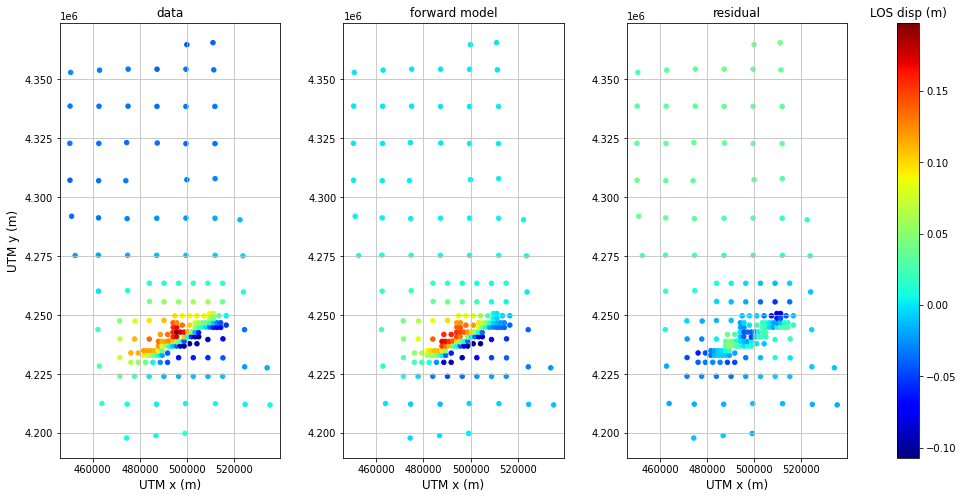

In [81]:
# calculate the displacements
model_los_disps = rect_shear_fault(best_fparams, eparams, data)

# calculate the mean residual
zero_shift = np.mean(data[:,2]-model_los_disps)

# calculate the residual without nuisances...
shifted_data = data[:,2]-zero_shift
residual_los_disps = model_los_disps-shifted_data

# color limits based on the shifted data
cmin, cmax = shifted_data.min(), shifted_data.max()

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
axlist = [ax1,ax2,ax3]   # handles for your subplots

# scatter with colormap mapping to z value
scat=ax1.scatter(data[:,0],data[:,1],s=20,c=shifted_data, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax1.set_xlabel("UTM x (m)",fontsize=12)
ax1.set_ylabel("UTM y (m)",fontsize=12)
ax1.title.set_text('data')
ax1.grid(True,linestyle='-',color='0.75')
ax1.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax2.scatter(data[:,0],data[:,1],s=20,c=model_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax2.set_xlabel("UTM x (m)",fontsize=12)
ax2.title.set_text('forward model')
ax2.grid(True,linestyle='-',color='0.75')
ax2.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax3.scatter(data[:,0],data[:,1],s=20,c=residual_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax3.set_xlabel("UTM x (m)",fontsize=12)
ax3.title.set_text('residual')
ax3.grid(True,linestyle='-',color='0.75')
ax3.set_aspect('equal')

clb=fig.colorbar(scat,ax=axlist)
clb.ax.set_title('LOS disp (m)')

plt.show();